## 전체 코드

### 데이터 준비
- mnist 데이터

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

### Custom Metrics
**custom mae**  
- MAE 전체 수식   
$mae = {1 \over n} * \sum_{i=1}^n |x_i - x| $
- 1차 수식 및 코드  
$\sum_{i=1}^n |x_i - x|$
```python
tf.reduce_sum(tf.abs(y_true-y_pred))
```
- 2차 수식 및 코드   
$sum * {1 \over n}$
```python
self.mae_sum / tf.cast(self.total_samples, tf.float32)
```

In [4]:
import tensorflow as tf

# Custom MAE Metrics
class MeanAbsoluteError(keras.metrics.Metric):
    def __init__(self, name='mae', **kargs):
        super().__init__(name=name, **kargs)
        
        self.mae_sum = self.add_weight(name='mae_sum', initializer='zeros')
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros', dtype='int32')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        
        # 1차 mae
        mae = tf.reduce_sum(tf.abs(y_true-y_pred))
        self.mae_sum.assign_add(mae)
        
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)
        
    def result(self):
        # mae 완성
        return self.mae_sum / tf.cast(self.total_samples, tf.float32)
    
    def reset_state(self):
        # 초기화
        self.mae_sum.assign(0.)
        self.total_samples.assign(0)

### Custom Callback

In [8]:
from matplotlib import pyplot as plt
import numpy as np

class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []
        self.per_batch_accuracy = []

    def on_batch_end(self, batch, logs):
        # batch end 시, loss 및 accuracy 값 저장
        self.per_batch_losses.append(logs.get("loss"))
        self.per_batch_accuracy.append(logs.get("accuracy"))

    def on_epoch_end(self, epoch, logs):
        # epoch end 시, plt 출력
        # 각 배치 훈련의 loss, accuracy 그래프 출력
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.plot(range(len(self.per_batch_accuracy)), self.per_batch_accuracy,
                 label="Training accuracy for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        self.per_batch_losses = []   
        self.per_batch_accuracy = []       
        plt.legend()
        plt.show()

# Early Stopping 구현
class CustomizedEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super().__init__()
        self.patience = patience
        self.stopped_epoch = 0
        self.best_weights = None
    
    def on_train_begin(self, logs):
        # old_val_loss는 np.Inf로 대체 (시작)
        self.old_val_loss = np.Inf
        self.continued_epoch=0
    
    def on_epoch_end(self, epoch, logs):
        val_loss = logs.get("val_loss")
        
        # 새 loss가 전 loss보다 높으면 다음 이벤트 발생
        if val_loss > self.old_val_loss:
            self.continued_epoch+=1
            if self.continued_epoch >= self.patience:
                self.stopped_epoch = epoch
                self.best_weights = self.model.get_weights()
                self.model.stop_training = True
        else:
            self.continued_epoch=0
        self.old_val_loss = val_loss
    
    def on_train_end(self, logs):
        # stopped_epoch이 0보다 크면 이벤트 발생
        if self.stopped_epoch > 0:
            print("Early stopping epoch: ", self.stopped_epoch + 1)

### 모델 실행

Epoch 1/8
1563/1563 [==============================] - 11s 6ms/step - loss: 0.2952 - accuracy: 0.9129 - mae: 56.0570 - val_loss: 0.1491 - val_accuracy: 0.9572 - val_mae: 56.0334


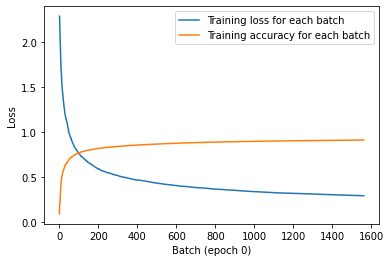

Epoch 2/8
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1627 - accuracy: 0.9549 - mae: 55.8526 - val_loss: 0.1231 - val_accuracy: 0.9683 - val_mae: 56.0007


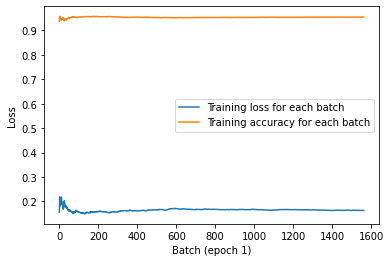

Epoch 3/8
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1370 - accuracy: 0.9630 - mae: 55.8703 - val_loss: 0.1171 - val_accuracy: 0.9698 - val_mae: 55.9905


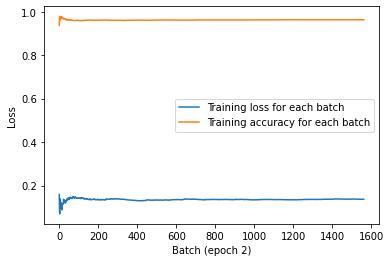

Epoch 4/8
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1259 - accuracy: 0.9671 - mae: 55.8532 - val_loss: 0.1037 - val_accuracy: 0.9753 - val_mae: 55.9737


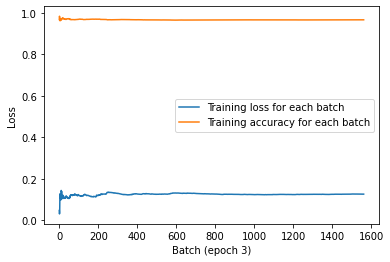

Epoch 5/8
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1136 - accuracy: 0.9718 - mae: 55.8395 - val_loss: 0.1176 - val_accuracy: 0.9737 - val_mae: 55.9782


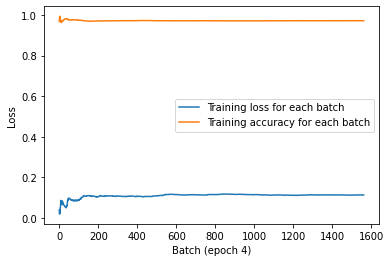

Early stopping epoch:  5


In [9]:
model = get_mnist_model()

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", MeanAbsoluteError()])

history = model.fit(train_images, train_labels,
          epochs=8,
          callbacks=[PlotLossAccuracy(), CustomizedEarlyStopping()],
          validation_data=(val_images, val_labels))

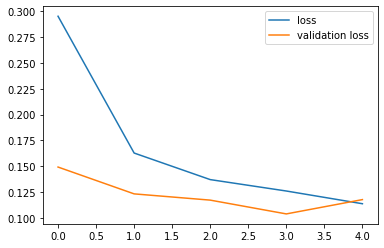

In [11]:
plt.plot(range(5), history.history['loss'], label='loss')
plt.plot(range(5), history.history['val_loss'], label='validation loss')
         
plt.legend()
plt.show()

## 회고
### Custom Model

- 그동안 궁금했던 다양한 입력, 출력을 가진 모델을 만들어 봄

### Playground
1. 8조에서 발표한 넓은 레이어와 좁은 레이어에서의 학습 차이
- 넓은 레이어일 수록 학습이 잘 되지만 차후에는 과적합 우려가 될 가능성이 보임
- 아마도 이미지 특징을 넓게 보면서 생기는 현상인듯 하다
2. 6조의 Layer가 깊어지는 경우도 재밌게 봤음
- Conv 1개, Dense 1개가 Conv 3개, Dense 3개보다 학습이 좋음